In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PSID
from PSID.evaluation import evalPrediction

# explore dimensions of behaviorally relevant dynamics
# in here all latent space dimensions will be used to prioritize behavior, meaning n1 = nx

PATH_FEATURES = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_USC/Code/Data/py_neuromodulation_derivatives/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_FEATURES.csv"
data_features = pd.read_csv(PATH_FEATURES, index_col=0)

In [2]:
def cross_validation_split(data, k_folds, k):
    size_fold = int(data.shape[0]/k_folds)
    test_set = data[k*size_fold:k*size_fold+size_fold]
    training_set = np.delete(data, np.arange(k*size_fold,k*size_fold+size_fold),axis=0)
    return test_set, training_set


def cross_validation(neural_data, behavior, k_folds, nx, n1, i, metrics = "R2"):
    """

    :param neural_data: time x neural data dimensions
    :param behavior: time x behavioral data dimensions
    :param k_folds: k fold CV
    :param nx: total dimension of the latent state
    :param n1: how many of those dimensions will be prioritizing behavior
    :param i: horizon, determines maximum n1 and nx: n1 <= nz * i. nx <= ny * i
    :param metrics: evaluation prediction metrics accepted by PSID
    :return:
    """
    eval_over_folds = np.zeros(k_folds)
    for k in range(k_folds):
        neural_data_test, neural_data_train = cross_validation_split(neural_data, k_folds, k)
        behavior_test, behavior_train = cross_validation_split(behavior, k_folds, k)

        idSys = PSID.PSID(neural_data_train, behavior_train, nx, n1, i)

        behavior_test_pred, neural_data_test_pred, x_test_pred = idSys.predict(neural_data_test)
        eval = evalPrediction(behavior_test, behavior_test_pred, metrics)

        print('Behavior decoding evaluation:\n  PSID => {:.3g}'.format(np.mean(eval)))
        eval_over_folds[k] = np.mean(eval)

    return eval_over_folds


In [3]:
feature_df = pd.concat([data_features.filter(like='STN'),data_features.filter(like='ECOG')], axis = 1).filter(like='bandpass_activity').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

K_FOLDS = 5
N_DIMS = 15

eval_over_dims = np.zeros((N_DIMS, K_FOLDS))
behavior_dims_latent = np.linspace(2, 30, N_DIMS, dtype=int)
for dim in range(N_DIMS):
    nx = n1 = behavior_dims_latent[dim]
    i = n1
    eval_over_dims[dim,:] = cross_validation(feature_df, behavior_df, K_FOLDS, nx, n1, i)

Behavior decoding evaluation:
  PSID => 0.608
Behavior decoding evaluation:
  PSID => 0.688
Behavior decoding evaluation:
  PSID => 0.672
Behavior decoding evaluation:
  PSID => 0.637
Behavior decoding evaluation:
  PSID => 0.618
Behavior decoding evaluation:
  PSID => 0.64
Behavior decoding evaluation:
  PSID => 0.738
Behavior decoding evaluation:
  PSID => 0.712
Behavior decoding evaluation:
  PSID => 0.637
Behavior decoding evaluation:
  PSID => 0.632
Behavior decoding evaluation:
  PSID => 0.642
Behavior decoding evaluation:
  PSID => 0.748
Behavior decoding evaluation:
  PSID => 0.727
Behavior decoding evaluation:
  PSID => 0.641
Behavior decoding evaluation:
  PSID => 0.648
Behavior decoding evaluation:
  PSID => 0.647
Behavior decoding evaluation:
  PSID => 0.76
Behavior decoding evaluation:
  PSID => 0.726
Behavior decoding evaluation:
  PSID => 0.646
Behavior decoding evaluation:
  PSID => 0.65
Behavior decoding evaluation:
  PSID => 0.657
Behavior decoding evaluation:
  PSID 

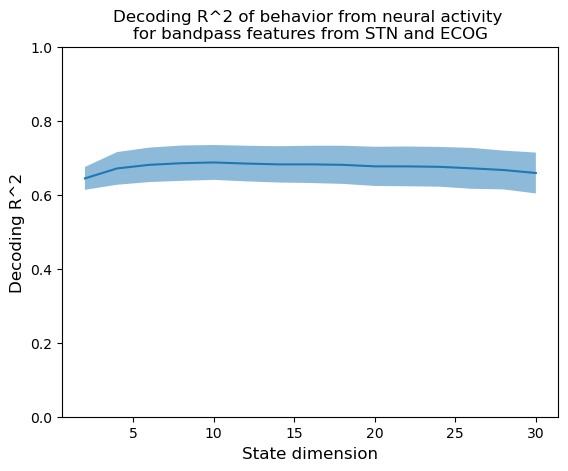

In [4]:
plt.plot(behavior_dims_latent, np.mean(eval_over_dims, axis = 1))
plt.fill_between(behavior_dims_latent, np.mean(eval_over_dims, axis = 1) - np.std(eval_over_dims, axis = 1), np.mean(eval_over_dims, axis = 1) + np.std(eval_over_dims, axis = 1), alpha = 0.5)
plt.ylim(0,1)
plt.ylabel("Decoding R^2", fontsize = 12)
plt.xlabel("State dimension", fontsize = 12)
plt.title("Decoding R^2 of behavior from neural activity \nfor bandpass features from STN and ECOG", fontsize = 12)
plt.show()

In [5]:
data_features.filter(like='STN').columns

Index(['STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Activity',
       'STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Mobility',
       'STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Complexity',
       'STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Activity',
       'STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Mobility',
       'STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Complexity',
       'STN_RIGHT_2-STN_RIGHT_1_RawHjorth_Activity',
       'STN_RIGHT_2-STN_RIGHT_1_RawHjorth_Mobility',
       'STN_RIGHT_2-STN_RIGHT_1_RawHjorth_Complexity',
       'STN_RIGHT_0-STN_RIGHT_2_bandpass_activity_theta',
       ...
       'STN_RIGHT_2-STN_RIGHT_1_bursts_high beta_duration_max',
       'STN_RIGHT_2-STN_RIGHT_1_bursts_high beta_amplitude_max',
       'STN_RIGHT_2-STN_RIGHT_1_bursts_high beta_burst_rate_per_s',
       'STN_RIGHT_2-STN_RIGHT_1_bursts_high beta_in_burst',
       'STN_RIGHT_2-STN_RIGHT_1_bursts_low gamma_duration_mean',
       'STN_RIGHT_2-STN_RIGHT_1_bursts_low gamma_amplitude_mean',
       'STN_RIGHT_2-STN_RIGHT_1_bursts_low gamma_duration_ma

In [6]:
feature_df = pd.concat([data_features.filter(like='STN'),data_features.filter(like='ECOG')], axis = 1).filter(like='fft').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

K_FOLDS = 5
N_DIMS = 15

eval_over_dims = np.zeros((N_DIMS, K_FOLDS))
behavior_dims_latent = np.linspace(2, 30, N_DIMS, dtype=int)
for dim in range(N_DIMS):
    nx = n1 = behavior_dims_latent[dim]
    i = n1
    eval_over_dims[dim,:] = cross_validation(feature_df, behavior_df, K_FOLDS, nx, n1, i)

Behavior decoding evaluation:
  PSID => -0.112
Behavior decoding evaluation:
  PSID => 0.196
Behavior decoding evaluation:
  PSID => 0.153
Behavior decoding evaluation:
  PSID => 0.278
Behavior decoding evaluation:
  PSID => 0.212
Behavior decoding evaluation:
  PSID => -1.54
Behavior decoding evaluation:
  PSID => 0.227
Behavior decoding evaluation:
  PSID => 0.193
Behavior decoding evaluation:
  PSID => 0.183
Behavior decoding evaluation:
  PSID => 0.0864
Behavior decoding evaluation:
  PSID => -1.61
Behavior decoding evaluation:
  PSID => 0.224
Behavior decoding evaluation:
  PSID => 0.228
Behavior decoding evaluation:
  PSID => 0.125
Behavior decoding evaluation:
  PSID => 0.106
Behavior decoding evaluation:
  PSID => -1.69
Behavior decoding evaluation:
  PSID => 0.196
Behavior decoding evaluation:
  PSID => 0.231
Behavior decoding evaluation:
  PSID => 0.104
Behavior decoding evaluation:
  PSID => 0.0959
Behavior decoding evaluation:
  PSID => -1.71
Behavior decoding evaluation:
 

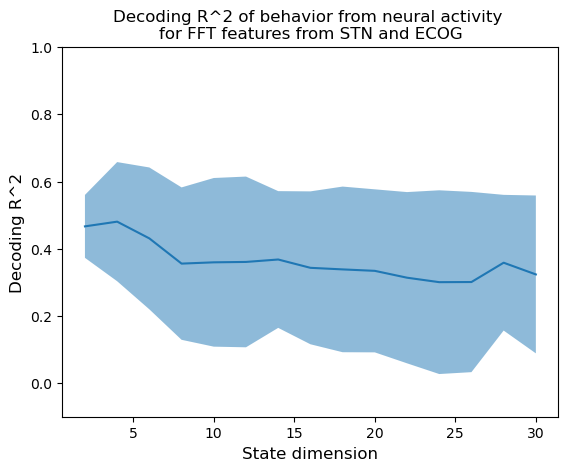

In [10]:
plt.plot(behavior_dims_latent, np.mean(eval_over_dims, axis = 1))
plt.fill_between(behavior_dims_latent, np.mean(eval_over_dims, axis = 1) - np.std(eval_over_dims, axis = 1), np.mean(eval_over_dims, axis = 1) + np.std(eval_over_dims, axis = 1), alpha = 0.5)
plt.ylim(-0.1,1)
plt.ylabel("Decoding R^2", fontsize = 12)
plt.xlabel("State dimension", fontsize = 12)
plt.title("Decoding R^2 of behavior from neural activity \nfor FFT features from STN and ECOG", fontsize = 12)
plt.show()

In [8]:
feature_df = pd.concat([data_features.filter(like='STN'),data_features.filter(like='ECOG')], axis = 1).filter(like='RawHjorth').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

K_FOLDS = 5
N_DIMS = 15

eval_over_dims = np.zeros((N_DIMS, K_FOLDS))
behavior_dims_latent = np.linspace(2, 30, N_DIMS, dtype=int)
for dim in range(N_DIMS):
    nx = n1 = behavior_dims_latent[dim]
    i = n1
    eval_over_dims[dim,:] = cross_validation(feature_df, behavior_df, K_FOLDS, nx, n1, i)

Behavior decoding evaluation:
  PSID => 0.399
Behavior decoding evaluation:
  PSID => 0.381
Behavior decoding evaluation:
  PSID => 0.403
Behavior decoding evaluation:
  PSID => 0.528
Behavior decoding evaluation:
  PSID => 0.622
Behavior decoding evaluation:
  PSID => 0.217
Behavior decoding evaluation:
  PSID => 0.576
Behavior decoding evaluation:
  PSID => 0.323
Behavior decoding evaluation:
  PSID => 0.66
Behavior decoding evaluation:
  PSID => 0.627
Behavior decoding evaluation:
  PSID => 0.0772
Behavior decoding evaluation:
  PSID => 0.555
Behavior decoding evaluation:
  PSID => 0.311
Behavior decoding evaluation:
  PSID => 0.546
Behavior decoding evaluation:
  PSID => 0.665
Behavior decoding evaluation:
  PSID => 0.0819
Behavior decoding evaluation:
  PSID => 0.544
Behavior decoding evaluation:
  PSID => 0.338
Behavior decoding evaluation:
  PSID => 0.141
Behavior decoding evaluation:
  PSID => 0.673
Behavior decoding evaluation:
  PSID => -0.085
Behavior decoding evaluation:
  

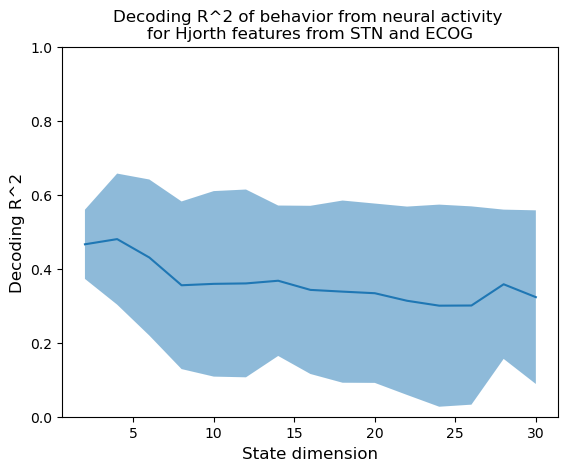

In [12]:
plt.plot(behavior_dims_latent, np.mean(eval_over_dims, axis = 1))
plt.fill_between(behavior_dims_latent, np.mean(eval_over_dims, axis = 1) - np.std(eval_over_dims, axis = 1), np.mean(eval_over_dims, axis = 1) + np.std(eval_over_dims, axis = 1), alpha = 0.5)
plt.ylim(0,1)
plt.ylabel("Decoding R^2", fontsize = 12)
plt.xlabel("State dimension", fontsize = 12)
plt.title("Decoding R^2 of behavior from neural activity \nfor Hjorth features from STN and ECOG", fontsize = 12)
plt.show()